# Compute Multiplier Analysis by Loss

This notebook computes how much less compute model A needs compared to model B to reach the same validation loss value.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import seaborn as sns


In [3]:
def find_closest_loss_row(
    df: pd.DataFrame, target_loss: float, loss_column: str = "validation_loss"
) -> Tuple[int, float, float]:
    """
    Find the row with validation loss closest to the target loss.

    Args:
        df: DataFrame with training data
        target_loss: Target loss value to find
        loss_column: Name of the loss column to search in

    Returns:
        Tuple of (row_index, actual_loss_found, compute_at_that_point)
    """
    if loss_column not in df.columns:
        raise ValueError(
            f"Column '{loss_column}' not found in DataFrame. Available columns: {list(df.columns)}"
        )

    if "total_flops_profiler" not in df.columns:
        raise ValueError(
            f"Column 'total_flops_profiler' not found in DataFrame. Available columns: {list(df.columns)}"
        )

    # Remove rows with NaN losses
    valid_df = df.dropna(subset=[loss_column])

    if len(valid_df) == 0:
        raise ValueError(f"No valid (non-NaN) values found in {loss_column} column")

    # Find the row with loss closest to target
    loss_differences = np.abs(valid_df[loss_column] - target_loss)
    closest_idx = loss_differences.idxmin()

    actual_loss = valid_df.loc[closest_idx, loss_column]
    compute_value = valid_df.loc[closest_idx, "total_flops_profiler"]

    return closest_idx, actual_loss, compute_value


def compute_multiplier_by_loss(
    csv_file_a: str,
    csv_file_b: str,
    target_loss: float,
    loss_column: str = "validation_loss",
    verbose: bool = True,
) -> Tuple[float, dict]:
    """
    Compute how much less compute model A needs vs model B to reach the same loss.

    Args:
        csv_file_a: Path to first CSV file (model A)
        csv_file_b: Path to second CSV file (model B)
        target_loss: Target loss value to compare at
        loss_column: Name of the loss column (default: 'validation_loss')
        verbose: Whether to print detailed information

    Returns:
        Tuple of (multiplier, details_dict) where:
        - multiplier: compute_B / compute_A (how many times less compute A needs)
        - details_dict: Dictionary with detailed information about the comparison
    """

    try:
        # Read the CSV files
        df_a = pd.read_csv(csv_file_a)
        df_b = pd.read_csv(csv_file_b)

        if verbose:
            print(f"Loaded {csv_file_a}: {len(df_a)} rows")
            print(f"Loaded {csv_file_b}: {len(df_b)} rows")

        # Find closest loss points in both files
        idx_a, loss_a, compute_a = find_closest_loss_row(df_a, target_loss, loss_column)
        idx_b, loss_b, compute_b = find_closest_loss_row(df_b, target_loss, loss_column)

        # Calculate multiplier (how many times less compute A needs vs B)
        multiplier = compute_b / compute_a

        # Prepare detailed results
        details = {
            "target_loss": target_loss,
            "model_a": {
                "file": csv_file_a,
                "closest_row": idx_a,
                "actual_loss": loss_a,
                "compute": compute_a,
                "loss_difference": abs(loss_a - target_loss),
            },
            "model_b": {
                "file": csv_file_b,
                "closest_row": idx_b,
                "actual_loss": loss_b,
                "compute": compute_b,
                "loss_difference": abs(loss_b - target_loss),
            },
            "multiplier": multiplier,
            "compute_ratio_b_to_a": multiplier,
            "percent_compute_reduction": (
                ((multiplier - 1) / multiplier) * 100 if multiplier > 1 else 0
            ),
        }

        if verbose:
            print(f"\nResults for target loss: {target_loss}")
            print("=" * 50)
            print(f"Model A ({csv_file_a}):")
            print(
                f"  Closest loss: {loss_a:.4f} (diff: {abs(loss_a - target_loss):.4f})"
            )
            print(f"  Compute: {compute_a:.2e} FLOPs")
            print(f"  Row index: {idx_a}")

            print(f"\nModel B ({csv_file_b}):")
            print(
                f"  Closest loss: {loss_b:.4f} (diff: {abs(loss_b - target_loss):.4f})"
            )
            print(f"  Compute: {compute_b:.2e} FLOPs")
            print(f"  Row index: {idx_b}")

            print(f"\nCompute Multiplier: {multiplier:.3f}x")
            if multiplier > 1:
                print(
                    f"Model A needs {multiplier:.3f}x LESS compute than Model B to reach loss {target_loss}"
                )
                print(
                    f"Compute reduction: {((multiplier - 1) / multiplier) * 100:.1f}%"
                )
            else:
                print(
                    f"Model A needs {1/multiplier:.3f}x MORE compute than Model B to reach loss {target_loss}"
                )

        return multiplier, details

    except Exception as e:
        print(f"Error computing multiplier: {e}")
        raise


def compare_multiple_loss_points(
    csv_file_a: str,
    csv_file_b: str,
    loss_points: list,
    loss_column: str = "validation_loss",
    plot: bool = True,
) -> pd.DataFrame:
    """
    Compare compute multipliers across multiple loss values.

    Args:
        csv_file_a: Path to first CSV file
        csv_file_b: Path to second CSV file
        loss_points: List of loss values to compare at
        loss_column: Name of the loss column
        plot: Whether to create a plot

    Returns:
        DataFrame with results for each loss point
    """

    results = []

    for target_loss in loss_points:
        try:
            multiplier, details = compute_multiplier_by_loss(
                csv_file_a, csv_file_b, target_loss, loss_column, verbose=False
            )

            results.append(
                {
                    "target_loss": target_loss,
                    "multiplier": multiplier,
                    "model_a_actual_loss": details["model_a"]["actual_loss"],
                    "model_b_actual_loss": details["model_b"]["actual_loss"],
                    "model_a_compute": details["model_a"]["compute"],
                    "model_b_compute": details["model_b"]["compute"],
                    "compute_reduction_percent": details["percent_compute_reduction"],
                }
            )

        except Exception as e:
            print(f"Error at loss {target_loss}: {e}")
            continue

    results_df = pd.DataFrame(results)

    if plot and len(results_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(
            results_df["target_loss"],
            results_df["multiplier"],
            "o-",
            linewidth=2,
            markersize=8,
        )
        plt.xlabel("Target Loss Value")
        plt.ylabel("Compute Multiplier (Model B / Model A)")
        plt.title(f"Compute Efficiency Comparison\n{csv_file_a} vs {csv_file_b}")
        plt.grid(True, alpha=0.3)
        plt.axhline(
            y=1, color="red", linestyle="--", alpha=0.5, label="No difference (1.0x)"
        )

        # Add value labels on points
        for _, row in results_df.iterrows():
            plt.annotate(
                f'{row["multiplier"]:.2f}x',
                (row["target_loss"], row["multiplier"]),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )

        plt.legend()
        plt.tight_layout()
        plt.show()

    return results_df


def analyze_loss_ranges(
    csv_file_a: str,
    csv_file_b: str,
    num_points: int = 10,
    loss_column: str = "validation_loss",
) -> pd.DataFrame:
    """
    Automatically analyze compute multipliers across the overlapping loss range.

    Args:
        csv_file_a: Path to first CSV file
        csv_file_b: Path to second CSV file
        num_points: Number of loss points to test
        loss_column: Name of the loss column

    Returns:
        DataFrame with results across the loss range
    """

    # Read files to determine overlapping loss range
    df_a = pd.read_csv(csv_file_a)
    df_b = pd.read_csv(csv_file_b)

    # Get valid loss ranges (excluding NaN values)
    valid_losses_a = df_a[loss_column].dropna()
    valid_losses_b = df_b[loss_column].dropna()

    # Find overlapping range
    min_loss_a, max_loss_a = valid_losses_a.min(), valid_losses_a.max()
    min_loss_b, max_loss_b = valid_losses_b.min(), valid_losses_b.max()

    overlap_min = max(min_loss_a, min_loss_b)
    overlap_max = min(max_loss_a, max_loss_b)

    print(f"Loss range overlap: {overlap_min:.3f} to {overlap_max:.3f}")

    if overlap_min >= overlap_max:
        raise ValueError("No overlapping loss range found between the two files")

    # Generate loss points in the overlapping range
    loss_points = np.linspace(overlap_min, overlap_max, num_points)

    return compare_multiple_loss_points(
        csv_file_a, csv_file_b, loss_points, loss_column
    )


In [4]:
# Fixed version that uses the provided colors instead of viridis
import os

def create_stacked_comparison_plot(
    stacked_groups, 
    comparison_data, 
    title="Stacked vs Single Comparison",
    bar_order=None,
    save_to_figures=True,
    fig_filename=None  # If None, will auto-generate name from title
):
    """
    Create a bar plot with multiple stacked bars and multiple single-value bars.
    Each stacked bar shows cumulative multiplicative effects.
    NOW USES THE PROVIDED COLORS instead of viridis!

    If save_to_figures is True, saves the plot to the Figures subdirectory
    with the filename fig_filename (or auto-generated from title).
    """

    # ===== EASILY ADJUSTABLE FONT SIZES =====
    title_fontsize = 25
    axis_label_fontsize = 23
    tick_label_fontsize = 20
    ytick_label_fontsize = 20
    legend_fontsize = 20
    component_label_fontsize = 16  # Reduced from 18
    value_label_fontsize = 17  # Reduced from 20
    total_label_fontsize = 15  # Reduced from 18
    # ========================================
    
    # Bar width (increased for better text fit)
    bar_width = 0.75  # Increased from 0.6

    # Use matplotlib's default style for cleaner log scale appearance
    # (Seaborn styles can interfere with log scale formatting)
    plt.style.use('default')

    # Handle bar ordering
    if bar_order is None:
        # Default: all stacked groups first, then all comparison items
        bar_order = [("stacked", i) for i in range(len(stacked_groups))] + \
                   [("comparison", i) for i in range(len(comparison_data))]

    # Set up bar positions
    total_bars = len(bar_order)
    x_positions = list(range(total_bars))

    # Create labels for each bar in the specified order
    labels = []
    for bar_type, bar_idx in bar_order:
        if bar_type == "stacked":
            components_data = stacked_groups[bar_idx]
            stacked_label = "Stacked:\n" + " \n × ".join(
                [comp[0] for comp in components_data]
            )
            labels.append(stacked_label)
        else:  # comparison
            name, value, color, *_ = comparison_data[bar_idx]
            labels.append(name)

    # Make figure object so we can save it
    fig = plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

    # Plot bars in the specified order
    all_max_values = []  # Track all heights for y-axis scaling

    for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
        if bar_type == "stacked":
            # Plot stacked bar
            components_data = stacked_groups[bar_idx]
            
            # Calculate cumulative multiplicative heights for this stacked bar
            cumulative_heights = [0.0]  # Start at 0
            running_product = 1.0  # Track the running product of multipliers

            for comp in components_data:
                multiplier = comp[1]
                running_product *= multiplier
                cumulative_heights.append(running_product)

            total_stacked_height = cumulative_heights[-1]
            all_max_values.append(total_stacked_height)

            # Plot stacked components with cumulative multiplicative effects
            for i, comp_data in enumerate(components_data):
                # Unpack with support for optional 5th element (display_name)
                name = comp_data[0]           # Clean name for x-axis labels
                value = comp_data[1]
                color = comp_data[2]
                text_color_val = comp_data[3] if len(comp_data) > 3 else None
                display_name = comp_data[4] if len(comp_data) > 4 else name  # Use display name if provided
                
                bottom = cumulative_heights[i]
                top = cumulative_heights[i + 1]
                segment_height = top - bottom

                # Use the provided color from the data
                bar = plt.bar(
                    x_positions[plot_idx],
                    segment_height,
                    bottom=bottom,
                    color=color,  # Use the provided color
                    width=bar_width,
                    label=(
                        f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
                    ),  # Only label first occurrence
                    alpha=0.85,
                    edgecolor="black",
                    linewidth=0.5,
                )

                # Add component labels in the middle of each segment
                if segment_height > 0.1:  # Only add label if segment is large enough
                    # Position text in the middle of the segment
                    text_y = bottom + segment_height / 2

                    # Ensure text is visible on log scale (at least at y=1.1)
                    # But only adjust if the segment actually crosses the y=1 threshold
                    if bottom < 1.0 and text_y < 1.1 and top > 1.0:
                        text_y = 1.1
                    
                    # Use text color from parameters if provided, otherwise alternate black/white
                    text_color_value = text_color_val if text_color_val else ("white" if i % 2 == 0 else "black")

                    plt.text(
                        x_positions[plot_idx],
                        text_y,
                        f"{display_name} {value:.2f}x",  # Use display_name for in-bar text
                        ha="center",
                        va="center",
                        fontsize=component_label_fontsize,
                        fontweight="bold",
                        color=text_color_value,
                    )

            # Add total height label for this stacked bar
            plt.text(
                x_positions[plot_idx],
                total_stacked_height + 0.2,
                f"Total: {total_stacked_height:.2f}x",
                ha="center",
                va="bottom",
                fontsize=total_label_fontsize,
                fontweight="bold",
                color="black",
            )

        else:  # comparison bar
            # Plot comparison bar
            name, value, color, *text_color = comparison_data[bar_idx]
            
            # Use the provided color from the data
            bar = plt.bar(
                x_positions[plot_idx],
                value,
                color=color,  # Use the provided color
                width=bar_width,
                label=f"{name} ({value:.2f}x)",
                alpha=0.85,
                edgecolor="black",
                linewidth=0.5,
            )

            all_max_values.append(value)

            # Add value labels on top
            plt.text(
                x_positions[plot_idx],
                value + 0.1,
                f"{value:.2f}x",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
            )

    # Customize plot with seaborn styling
    plt.xticks(
        x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
    )
    plt.ylabel(
        "Compute Effect Multiplier (log scale)", fontsize=axis_label_fontsize, fontweight="bold"
    )
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    
    # Set y-axis limits BEFORE setting log scale
    max_value = max(all_max_values) if all_max_values else 2.0
    plt.ylim(1, max_value * 1.4)
    
    # Set log scale - matplotlib will automatically format it properly
    plt.yscale("log")
    
    # Enable grid for both major and minor ticks
    plt.grid(axis="y", linestyle="--", alpha=0.3, which="both")

    # Get axes and configure for standard log scale appearance
    ax = plt.gca()
    
    # Let matplotlib use its default log scale formatting (standard appearance)
    # Just adjust font size and tick appearance
    ax.tick_params(axis="y", which="major", labelsize=ytick_label_fontsize)
    ax.tick_params(axis="y", which="minor", labelsize=0)  # Hide minor tick labels but show ticks

    plt.tight_layout()

    # === NEW: Save the plot to the Figures/ folder ===
    if save_to_figures:
        # Find the directory of the notebook or script
        local_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
        # Target directory
        figures_dir = os.path.join(local_dir, "Figures")
        os.makedirs(figures_dir, exist_ok=True)
        # Make a nice filename if not supplied
        if fig_filename is None:
            # Slugify the title for filename
            simple_name = title.lower().replace(" ", "_").replace("\n", "_")
            simple_name = "".join([c for c in simple_name if c.isalnum() or c in ("_", "-")])
            fig_filename = f"{simple_name}.png"
        save_path = os.path.join(figures_dir, fig_filename)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
        print(f"Figure saved to: {save_path}")

    plt.show()

    # Print summary
    print(f"\nSummary:")

    # Print each stacked group in the order they appear
    stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
    for plot_order, group_idx in enumerate(stacked_group_indices):
        components_data = stacked_groups[group_idx]
        
        # Recalculate cumulative heights for printing
        cumulative_heights = [0.0]
        running_product = 1.0
        for comp in components_data:
            running_product *= comp[1]
            cumulative_heights.append(running_product)

        total_stacked_height = cumulative_heights[-1]

        print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
        print("  Cumulative breakdown:")
        for i, (name, value, *_) in enumerate(components_data):
            cumulative = cumulative_heights[i + 1]
            print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

    # Print comparison values in the order they appear
    comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
    if comparison_indices:
        print(f"\nComparison values:")
        for plot_order, comp_idx in enumerate(comparison_indices):
            name, value, *_ = comparison_data[comp_idx]
            position = bar_order.index(('comparison', comp_idx)) + 1
            print(f"  {name} (Position {position}): {value:.2f}x")


# Bar Plot Examining Interactions

Figure saved to: /Users/hansgundlach/Documents/MITresearch/Experimental_Progress/experimental_analysis/Figures/interaction_between_algorithmic_components.png


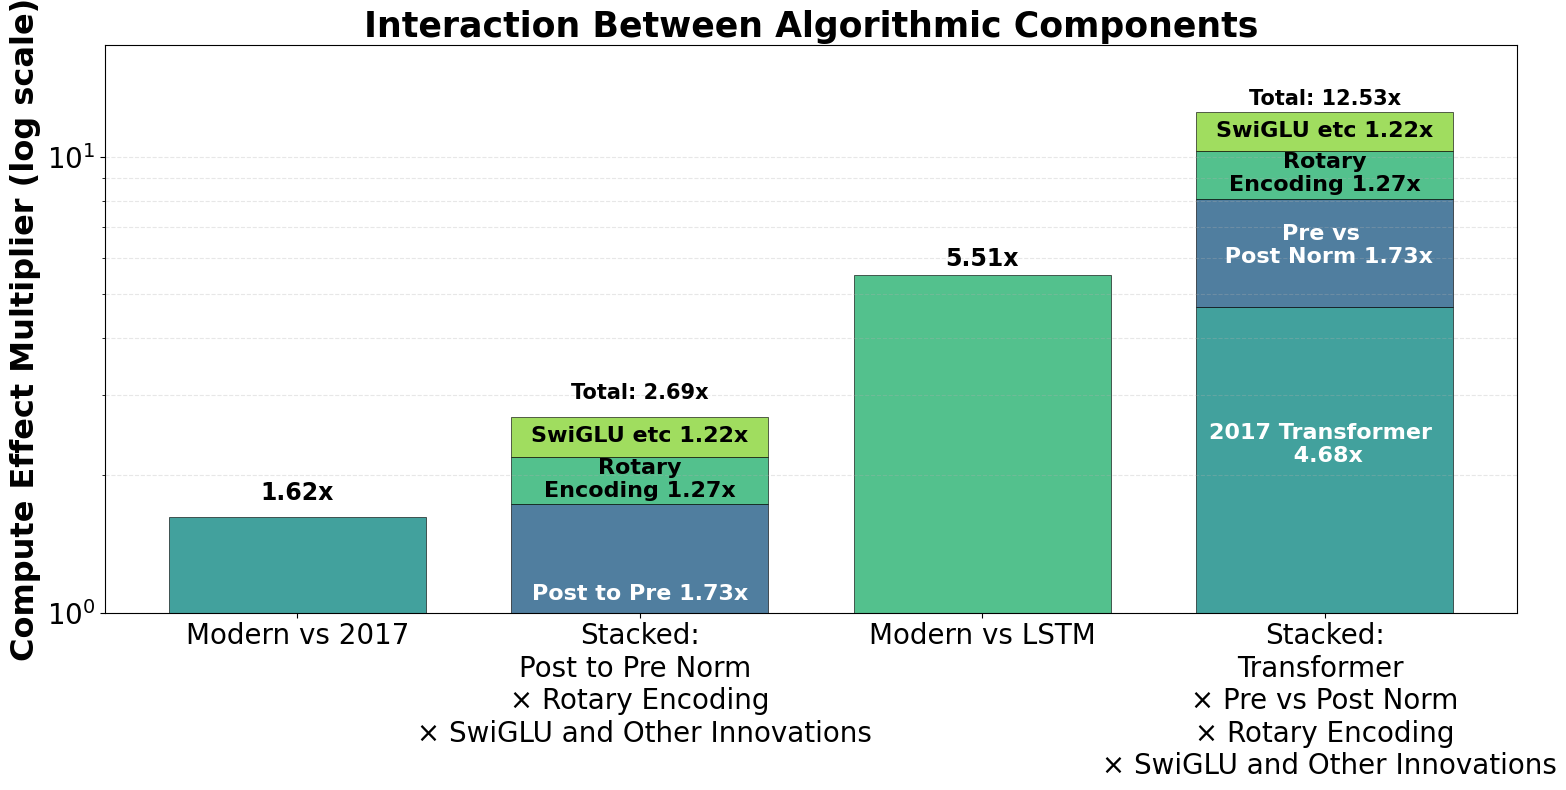


Summary:

Stacked Group 1 (Position 2) - Total: 2.69x
  Cumulative breakdown:
    After Post to Pre Norm: 1.73x (×1.73)
    After Rotary Encoding: 2.20x (×1.27)
    After SwiGLU and Other Innovations: 2.69x (×1.22)

Stacked Group 2 (Position 4) - Total: 12.53x
  Cumulative breakdown:
    After Transformer: 4.68x (×4.68)
    After Pre vs Post Norm: 8.10x (×1.73)
    After Rotary Encoding: 10.27x (×1.27)
    After SwiGLU and Other Innovations: 12.53x (×1.22)

Comparison values:
  Modern vs 2017 (Position 1): 1.62x
  Modern vs LSTM (Position 3): 5.51x


In [7]:
# Example: Custom bar ordering
# Let's say you want: comparison first, then stacked, then comparison again


# viridis_colors = ["#440154", "#31688e", "#35b779", "#fde725"]  
viridis_colors = sns.color_palette("viridis", n_colors=5)
stacked_groups_custom = [
    # First stacked bar
    # Format: (clean_name, value, color, text_color, display_name)
    [
        ("Post to Pre Norm", 1.73, viridis_colors[1], "white", "Post to Pre"),
        ("Rotary Encoding", 1.269, viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations", 1.224, viridis_colors[4], "black", "SwiGLU etc"),

    ],
    # Second stacked bar 
    [
        ("Transformer", 4.68, viridis_colors[2], "white", "2017 Transformer \n"),
        ("Pre vs Post Norm", 1.73, viridis_colors[1], "white", "Pre vs \n Post Norm"),
        ("Rotary Encoding", 1.269, viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations", 1.22, viridis_colors[4], "black", "SwiGLU etc"),
 
    ],
]
# "#e74c3c"


comparison_data_custom = [
    ("Modern vs 2017", 1.62, viridis_colors[2], "white"),
    ("Modern vs LSTM", 5.51, viridis_colors[3], "black"),
]

# Custom order: comparison first, then stacked, then comparison again
custom_bar_order = [
    ("comparison", 0),    # 1st bar: "Current vs 2017" 
    ("stacked", 0),       # 2nd bar: First stacked group (Rotary + SwiGLU)
    ("comparison", 1),    # 3rd bar: "Ho et Al"
    ("stacked", 1),       # 4th bar: Second stacked group (Component A + Component B)
]

create_stacked_comparison_plot(
    stacked_groups_custom,
    comparison_data_custom,
    "Interaction Between Algorithmic Components",
    bar_order=custom_bar_order
)


# Overall Algorithm Accounting

In [12]:
# # Example 4: 5 stacked components vs 3 comparisons
# components_data_3 = [
#     ("Optimizer", 2.8, '#e74c3c'),
#     ("Architecture", 2.2, '#3498db'),
#     ("Initialization", 1.6, '#2ECC71'),
#     ("Regularization", 1.3, '#f39c12'),
#     ("Data Augmentation", 1.2, '#9b59b6')
# ]

# comparison_data_3 = [
#     ("Baseline", 1.0, '#95a5a6'),
#     ("Partial Improvement", 4.5, '#e67e22'),
#     ("Full Pipeline", 8.2, '#1abc9c')
# ]

# create_stacked_comparison_plot(
#     components_data_3,
#     comparison_data_3,
#     "Complete ML Pipeline Components"
# )


In [13]:
# Orthogonal
